In [3]:
# using PlotlyJS
using Plots
using PyCall
using Printf
using LsqFit
using LinearAlgebra
using Statistics
# using Flux
using Random
using ForwardDiff
# using Distributed
# using Base.Threads
# using Pkg
# using Optim
gr()  

Plots.GRBackend()

In [21]:
function testLossDerivative(structuralParameterIndex::Int64, structuralParameterForDerivative)
    # println(typeof(structuralParameterForDerivative))
    T = typeof(structuralParameterForDerivative)
    dump(structuralParameterForDerivative)
    mlem::Vector{T} = zeros(3)
    println("ello guv")
    mlem[2] += structuralParameterForDerivative
    mlem[2] += structuralParameterForDerivative
    println("das ist meine beruf")
    println(mlem)
    typeof(mlem)
    return structuralParameterForDerivative
end
ForwardDiff.derivative(structuralParameterForDerivative -> testLossDerivative(1, structuralParameterForDerivative), 1.0)

ForwardDiff.Dual{ForwardDiff.Tag{var"#51#52", Float64}, Float64, 1}
  value: Float64 1.0
  partials: ForwardDiff.Partials{1, Float64}
    values: Tuple{Float64}
      1: Float64 1.0
ello guv
das ist meine beruf
ForwardDiff.Dual{ForwardDiff.Tag{var"#51#52", Float64}, Float64, 1}[Dual{ForwardDiff.Tag{var"#51#52", Float64}}(0.0,0.0), Dual{ForwardDiff.Tag{var"#51#52", Float64}}(1.0,1.0), Dual{ForwardDiff.Tag{var"#51#52", Float64}}(0.0,0.0)]


1.0

In [5]:
sort([2,3,1])
structuralParameters

5-element Vector{Float64}:
   0.96446195
   1.68888476
 103.0
   2.3
   1.0

In [14]:
filter((x) -> 0 < abs(x) <= 1e-12, xiMatrix)
sort(energies)
energies[sortperm(energies)]

6132-element Vector{Float64}:
     0.0
     2.4525783509016037
     2.4752040058374405
     3.1935482174158096
     5.064237400889397
     5.068974778056145
     6.149379909038544
     6.427855923771858
     6.446180284023285
     6.449192136526108
     ⋮
 36875.424885585904
 37229.21902105212
 37326.778317168355
 37383.726616472006
 37516.367436259985
 37624.88181474805
 37987.077087417245
 40153.84384831786
 40544.23138128221

In [ ]:
function gradient_descent_step(θ, lossfn, lr)
    grad = ForwardDiff.gradient(lossfn, θ)
    return θ .- lr .* grad
end

for epoch in 1:epochs
    lossval = loss(θ, xdata, ydata, weights)
    θ = gradient_descent_step(θ, p -> loss(p, xdata, ydata, weights), lr)
    println("Epoch $epoch, Loss = $lossval")
end

In [51]:
include("ABC.jl")

hartreeToWavenumberConversion::Float64 = 2.194746354e5
convertToRadians::Float64 = pi/180

# inputFileName::String = "HOCl-VQ+dZ"
inputFileName::String = "HOCl-VQZ-fit"
# inputFileName::String = "HOCl-VQZ-1D-rOH"
potentialInputFilePath::String = inputFileName*".inp"

keywords::Vector{String} = ["structural", "linear", "grid"]
inputBlocks::Vector{Vector{String}} = []
open(potentialInputFilePath, "r") do potentialInputFile::IOStream
    input::Vector{String} = readlines(potentialInputFile)
    addToBlock::Bool = false
    for keyword in keywords
        newBlock::Vector{String} = []
        for line in input
            if lowercase(line) == lowercase(keyword)
                addToBlock = true
            elseif lowercase(line) == "end"
                addToBlock = false
            end
            if addToBlock
                push!(newBlock, line)
            end
        end
        push!(inputBlocks, newBlock)
    end
end

structuralParameterBlock::Vector{String} = inputBlocks[1][2:end]
numberOfStructuralParameters::Int64 = size(structuralParameterBlock)[1] - 1
structuralParameterBlockSplit::Vector{Vector{SubString{String}}} = split.(structuralParameterBlock, r"\s+")
numberOfMorseParameters::Int64 = parse(Int64, structuralParameterBlockSplit[1][2])
numberOfEquilibriumParameters::Int64 = numberOfStructuralParameters - numberOfMorseParameters
numberOfModes::Int64 = size(structuralParameterBlockSplit[2])[1] - 3
numberOfAtoms::Int64 = (numberOfModes + 6)/3
numberOfStretches::Int64 = numberOfAtoms - 1
numberOfBondAngles::Int64 = numberOfAtoms - 2
numberOfDihedrals::Int64 = numberOfAtoms - 3

structuralParameters::Vector{Float64} = zeros(numberOfStructuralParameters)
structuralParameterLabels::Vector{String} = []
structuralPowers::Matrix{Int64} = zeros(numberOfStructuralParameters, numberOfModes)
structuralParametersOn::Vector{Int64} = zeros(numberOfStructuralParameters)
for i in 1:numberOfStructuralParameters
    structuralParameters[i] = parse(Float64, structuralParameterBlockSplit[i + 1][end])
    push!(structuralParameterLabels, String(structuralParameterBlockSplit[i + 1][1]))
    structuralPowers[i, :] = parse.(Int64, structuralParameterBlockSplit[i + 1][2:end-2])
    structuralParametersOn[i] = parse(Float64, structuralParameterBlockSplit[i + 1][end - 1])
end

linearParameterBlock::Vector{String} = inputBlocks[2][2:end]
numberOfLinearParameters::Int64 = size(linearParameterBlock)[1]
linearParameterBlockSplit::Vector{Vector{SubString{String}}} = split.(linearParameterBlock, r"\s+")

linearParameters::Vector{Float64} = zeros(numberOfLinearParameters)
linearParameterLabels::Vector{String} = []
linearPowers::Matrix{Int64} = zeros(numberOfLinearParameters, numberOfModes)
linearParametersOn::Vector{Int64} = zeros(numberOfLinearParameters)

for i in 1:numberOfLinearParameters
    linearParameters[i] = parse(Float64, linearParameterBlockSplit[i][end])
    push!(linearParameterLabels, String(linearParameterBlockSplit[i][1]))
    linearPowers[i, :] = parse.(Int64, linearParameterBlockSplit[i][2:end-2])
    linearParametersOn[i] = parse(Float64, linearParameterBlockSplit[i][end - 1])
end

allParameters::Vector{Float64} = vcat(structuralParameters, linearParameters)
allParameterLabels::Vector{String} = vcat(structuralParameterLabels, linearParameterLabels)
allPowers::Matrix{Int64} = vcat(structuralPowers, linearPowers)
allParametersOn::Vector{Int64} = vcat(structuralParametersOn, linearParametersOn)
numberOfParameters::Int64 = length(allParameters)
 
gridBlock::Vector{String} = inputBlocks[3][2:end]
numberOfGridPoints::Int64 = size(gridBlock)[1] 
gridBlockSplit::Vector{Vector{SubString{String}}} = split.(gridBlock, r"\s+")

grid::Matrix{Float64} = zeros(numberOfGridPoints, numberOfModes)
gridValenceCoordinates::Matrix{Float64} = zeros(numberOfGridPoints, numberOfModes)
energies::Vector{Float64} = zeros(numberOfGridPoints)

for i in 1:numberOfGridPoints
    grid[i, :]  = parse.(Float64, gridBlockSplit[i][1:numberOfModes])
    gridValenceCoordinates[i, :] = defineInternalCoordinates(grid[i, :])
    energies[i] = parse(Float64, gridBlockSplit[i][numberOfModes+1])
end

referenceGeometry::Vector{Float64} = gridValenceCoordinates[1, :] 

energies = energies.*hartreeToWavenumberConversion
minimumEnergy::Float64 = minimum(energies)
println()
# @printf("%12.10f \n", minimumEnergy)
energies = energies.-minimumEnergy

# meanEnergy::Float64 = mean(energies)
# energyStandardDeviation::Float64 = std(energies)
# energiesScaled::Vector{Float64} = (energies .- meanEnergy)./energyStandardDeviation

# Weight factor by Partridge and Schwenke
function computeWeightOfPoint(energy::Float64, energyThreshold=20000.0::Float64, energyMax=10000.0::Float64)::Float64
    weight::Float64 = (tanh(−0.0006*(energy - energyThreshold)) + 1.002002002)/2.002002002
    if energy > energyMax
        weight = weight/(0.0001*energy)
    else
        weight = weight/(0.0001*energyMax)
    end
    return weight
end

weights::Vector{Float64} = computeWeightOfPoint.(energies)
weightsSqrt::Vector{Float64} = sqrt.(weights)


# function potentialEnergyModel(gridValenceCoordinates::Matrix{Float64}, parametersToFit::Vector{Float64})::Vector{Float64}
#     parametersToFit = [allParametersOn[i] == 1 ? parametersToFit[i] : allParameters[i] for i in 1:length(allParametersOn)]
#     numberOfGridPoints::Int64 = size(gridValenceCoordinates)[1]
#     alphaEq::Float64 = parametersToFit[3]*convertToRadians
#     displacementROH::Vector{Float64} = gridValenceCoordinates[:, 1] .- parametersToFit[1]
#     displacementROCL::Vector{Float64} = gridValenceCoordinates[:, 2] .- parametersToFit[2]
#     xiGrid::Matrix{Float64} = zeros(numberOfGridPoints, numberOfModes)
#     xiGrid[:, 1] = 1.0 .- exp.(-parametersToFit[4]*displacementROH)
#     xiGrid[:, 2] = 1.0 .- exp.(-parametersToFit[5]*displacementROH)
#     xiGrid[:, 3] = cos(alphaEq) .- cos.(gridValenceCoordinates[:, 3])
#     predictedEnergies::Vector{Float64} = zeros(numberOfGridPoints)
#     for i in numberOfStructuralParameters+1:numberOfParameters
#         for j in 1:numberOfGridPoints
#             predictedEnergies[j] += parametersToFit[i]*prod(xiGrid[j, :].^allPowers[i, :])
#         end
#     end
#     return predictedEnergies
# end
function generateXiMatrix(gridValenceCoordinates::Matrix{Float64}, structuralParameters)
    T::DataType = eltype(structuralParameters)
    numberOfGridPoints::Int64 = size(gridValenceCoordinates)[1]
    xiMatrix::Matrix{T} = zeros(numberOfGridPoints, numberOfLinearParameters)
    for i in 1:numberOfGridPoints
        xi::Vector{T} = defineXiCoordinates(gridValenceCoordinates[i, :], structuralParameters)
        for j in 1:numberOfLinearParameters
            xiMatrix[i, j] = prod(xi.^linearPowers[j, :])
        end
    end
    return xiMatrix
end

structuralParameters::Vector{Float64} = convertAnglesToRadians(structuralParameters)

xiMatrix::Matrix{Float64} = generateXiMatrix(gridValenceCoordinates, structuralParameters)
normalizationMeans::Vector{Float64} = zeros(numberOfLinearParameters)
normalizationStandardDeviation::Vector{Float64} = ones(numberOfLinearParameters)
normalizationMeans[2:end] = mean(xiMatrix[:, 2:end], dims=1)[1, :]
normalizationStandardDeviation[2:end] = std(xiMatrix[:, 2:end], dims=1)[1, :]

normalizedXiMatrix::Matrix{Float64} = (xiMatrix .- normalizationMeans')./normalizationStandardDeviation'

function computeJacobian(xiMatrix::Matrix{Float64}, linearParameters::Vector{Float64}, energies::Vector{Float64}, weights::Vector{Float64})::Vector{Float64}
    numberOfGridPoints::Int64 = length(energies)
    residuals::Vector{Float64} = xiMatrix*linearParameters .- energies
    gradientVector::Vector{Float64} = 2*xiMatrix'*(weights.*residuals)/numberOfGridPoints
    return gradientVector
end

function getBatches(grid::Matrix{Float64}, energies::Vector{Float64}, weights::Vector{Float64}, batchSize::Int64)::Vector{Tuple{Matrix{Float64}, Vector{Float64}, Vector{Float64}}}
    numberOfGridPoints::Int64 = length(energies)
    indices::Vector{Int64} = randperm(numberOfGridPoints)
    batches::Vector{Tuple{Matrix{Float64}, Vector{Float64}, Vector{Float64}}} = []
    for i in 1:batchSize:numberOfGridPoints
        batchIndices::Vector{Int64} = indices[i:min(i + batchSize - 1, end)]
        push!(batches, (grid[batchIndices, :], energies[batchIndices], weights[batchIndices]))
    end
    return batches
end

ϵ::Float64 = 1e-6
epochs::Int64 = 2
for epoch in 1:epochs
    residuals::Vector{Float64} = normalizedXiMatrix*linearParameters .- energies
    weights = computeWeightOfPoint.(energies)./(residuals.^2 .+ ϵ)
    weightsSqrt = sqrt.(weights)
    println("Normal eqation reweighted solution $(epoch - 1), Loss = ", sum(weights.*residuals.^2)/numberOfGridPoints)
    Q, R = qr(Diagonal(weightsSqrt)*normalizedXiMatrix)
    linearParameters = R \ (Matrix(Q)' * (energies.*weightsSqrt))
    # linearParameters = normalizedXiMatrix.*weightsSqrt \ (energies.*weightsSqrt)
end
println("linear part done")

function computeLossFromStructuralParameters(gridValenceCoordinates::Matrix{Float64}, energies::Vector{Float64}, weights::Vector{Float64}, structuralParameterIndex::Int64, structuralParameterForDerivative)
    # println("I've lost my battle before it starts")
    T::DataType = typeof(structuralParameterForDerivative)
    numberOfGridPoints::Int64 = length(energies)
    structuralParametersInLossFunction::Vector{T} = copy(structuralParameters) # zeros(numberOfStructuralParameters)
    structuralParametersInLossFunction[structuralParameterIndex] = structuralParameterForDerivative
    # println("My first breath wasn't done")
    xiMatrix::Matrix{T} = generateXiMatrix(gridValenceCoordinates, structuralParametersInLossFunction)
    # println("My spirits sunken deep into the ground")
    normalizedXiMatrix::Matrix{T} = (xiMatrix .- normalizationMeans')./normalizationStandardDeviation'
    # println("Why am I alone?")
    loss::T = sum(weights.*(normalizedXiMatrix*linearParameters .- energies).^2)/numberOfGridPoints
    return loss
end

batchSize::Int64 = 250
learningRate::Float64 = 0.01
epochs = 50
# structuralParametersBeingFit::Vector{Float64} = copy(structuralParameters)
for epoch in 1:epochs
    for (gridBatch, energyBatch, weightBatch) in getBatches(gridValenceCoordinates, energies, weights, batchSize)
        xiMatrixBatch::Matrix{Float64} = generateXiMatrix(gridBatch, structuralParameters)
        # xiMatrixBatch = (xiMatrixBatch .- normalizationMeans')./normalizationStandardDeviation'
        gradientVectorStructuralParameters::Vector{Float64} = zeros(numberOfStructuralParameters)
        for i in 1:numberOfStructuralParameters
            if structuralParametersOn[i] == 1
                gradientVectorStructuralParameters[i] = ForwardDiff.derivative(structuralParameter -> computeLossFromStructuralParameters(gridBatch, energyBatch, weightBatch, i, structuralParameter), structuralParameters[i])
            end
        end
        println(gradientVectorStructuralParameters)
        structuralParameters -= learningRate*gradientVectorStructuralParameters
        gradientVectorLinearParameters::Vector{Float64} = computeJacobian(xiMatrixBatch, linearParameters, energyBatch, weightBatch)
        linearParameters -= learningRate*gradientVectorLinearParameters
    end
    # println("Epoch $epoch, Loss = ", sum(weights.*(normalizedXiMatrix*linearParameters .- energies).^2)/numberOfGridPoints)
    println("Epoch $epoch, Loss = ", sum(weights.*(xiMatrix*linearParameters .- energies).^2)/numberOfGridPoints)
    # println("Epoch $epoch, Loss = ", loss(newParameters, gridValenceCoordinates, energies, weights))
end


for i in 2:numberOfLinearParameters
    linearParameters[1] -= linearParameters[i]*normalizationMeans[i]/normalizationStandardDeviation[i]
    linearParameters[i] /= normalizationStandardDeviation[i]
end

sortedEnergyOrderingIndices::Vector{Int64} = sortperm(energies)
energies = energies[sortedEnergyOrderingIndices]
grid = grid[sortedEnergyOrderingIndices, :]
xiMatrix = xiMatrix[sortedEnergyOrderingIndices, :]

computedEnergies::Vector{Float64} = xiMatrix*linearParameters
residuals::Vector{Float64} = energies .- computedEnergies

structuralParameters = convertAnglesToDegrees(structuralParameters)

fittedParameters::Vector{Float64} = vcat(structuralParameters, linearParameters)

open(inputFileName*".out", "w") do outputFile::IOStream
    println(outputFile, "New model:")
    for i in 1:numberOfParameters
        @printf(outputFile, "f   %4.0f %4.0f %4.0f  %12.12f\n", allPowers[i, 1], allPowers[i, 2], allPowers[i, 3], fittedParameters[i])
    end
    println(outputFile, )
    println(outputFile, "Grid of energies:")
    for i in 1:numberOfGridPoints
        @printf(outputFile, "%12.8f %12.8f %12.8f  %12.12f %12.12f %12.12f\n", grid[i, 1], grid[i, 2], grid[i, 3],  energies[i], computedEnergies[i], residuals[i])
    end
end


Normal eqation reweighted solution 0, Loss = 0.9284978086459149
Normal eqation reweighted solution 1, Loss = 0.9257121083239044
linear part done
[17940.938846495523, -72224.49570755757, -50910.50983007269, 0.0, 0.0]
[NaN, NaN, NaN, 0.0, 0.0]
[NaN, NaN, NaN, 0.0, 0.0]
[NaN, NaN, NaN, 0.0, 0.0]
[NaN, NaN, NaN, 0.0, 0.0]
[NaN, NaN, NaN, 0.0, 0.0]
[NaN, NaN, NaN, 0.0, 0.0]
[NaN, NaN, NaN, 0.0, 0.0]
[NaN, NaN, NaN, 0.0, 0.0]
[NaN, NaN, NaN, 0.0, 0.0]
[NaN, NaN, NaN, 0.0, 0.0]
[NaN, NaN, NaN, 0.0, 0.0]
[NaN, NaN, NaN, 0.0, 0.0]
[NaN, NaN, NaN, 0.0, 0.0]
[NaN, NaN, NaN, 0.0, 0.0]
[NaN, NaN, NaN, 0.0, 0.0]
[NaN, NaN, NaN, 0.0, 0.0]
[NaN, NaN, NaN, 0.0, 0.0]
[NaN, NaN, NaN, 0.0, 0.0]
[NaN, NaN, NaN, 0.0, 0.0]
[NaN, NaN, NaN, 0.0, 0.0]
[NaN, NaN, NaN, 0.0, 0.0]
[NaN, NaN, NaN, 0.0, 0.0]
[NaN, NaN, NaN, 0.0, 0.0]
[NaN, NaN, NaN, 0.0, 0.0]
Epoch 1, Loss = NaN
[NaN, NaN, NaN, 0.0, 0.0]
[NaN, NaN, NaN, 0.0, 0.0]
[NaN, NaN, NaN, 0.0, 0.0]
[NaN, NaN, NaN, 0.0, 0.0]
[NaN, NaN, NaN, 0.0, 0.0]
[NaN, NaN

InterruptException: InterruptException:

In [24]:
ForwardDiff.gradient(x -> sum(x.^2), [6.0])

1-element Vector{Float64}:
 12.0

In [148]:
normalizedXiMatrix

6132×162 Matrix{Float64}:
 1.0  -0.261329   0.353166   -0.375514  …   0.0213668  -0.028987    0.0167644
 1.0  -0.261329   0.353166   -0.375514      0.0213668  -0.028987    0.0167644
 1.0  -0.261329   0.353166   -0.375514      0.0213668  -0.028987    0.0167644
 1.0  -0.261329   0.353166   -0.375514      0.0213668  -0.028987    0.0167644
 1.0  -0.261329   0.353166   -0.375514      0.0213668  -0.028987    0.0167644
 1.0  -0.261329   0.353166   -0.375514  …   0.0213668  -0.028987    0.0167644
 1.0  -0.261329   0.353166   -0.375514      0.0213668  -0.028987    0.0167644
 1.0  -0.261329   0.353166   -0.375514      0.0213668  -0.028987    0.0167644
 1.0  -0.261329   0.353166   -0.375514      0.0213668  -0.028987    0.0167644
 1.0  -0.261329   0.353166   -0.375514      0.0213668  -0.028987    0.0167644
 ⋮                                      ⋱               ⋮          
 1.0  -0.325546   0.396805   -0.401979      0.0215251  -0.0289681   0.0167918
 1.0  -0.9709     0.722465   -0.554911      0.02

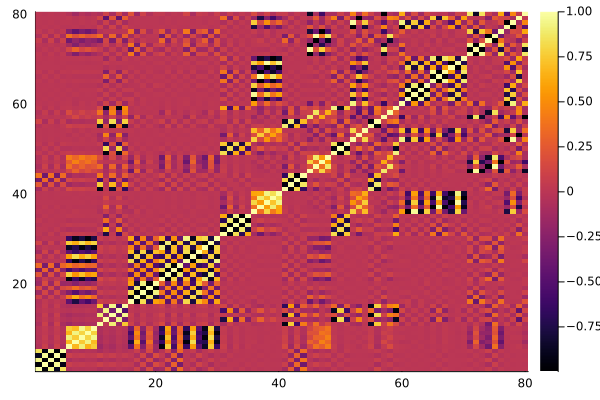

In [104]:
correlationMatrix::Matrix{Float64} = cor(normalizedXiMatrix)
heatmap(correlationMatrix)

In [19]:
residuals::Vector{Float64} = energies - normalizedXiMatrix*linearParameters 

6132-element Vector{Float64}:
   0.5425541767959712
   0.4884777780571863
   0.6020795461633641
   0.44127640140743196
   0.6670559529266775
   0.4013568988609819
   0.7365387928944642
   0.36913435726680177
   0.8093942932990075
   0.3456404629172596
   ⋮
   0.49086970649545947
   4.304066532797151
   0.19770890325526125
   1.567667998810066
  -1.8199954651681765
 -25.522322452261506
 -13.002008633748119
   1.121959135986799
   0.2785272751875709

In [105]:
correlationMatrix

80×80 Matrix{Float64}:
  1.0          -0.980063      0.940729     …  -0.000496966   0.00608187
 -0.980063      1.0          -0.988601         0.000454093  -0.0080453
  0.940729     -0.988601      1.0             -0.000430848   0.00843208
 -0.895471      0.962721     -0.992144         0.000448196  -0.00811066
  0.848723     -0.929332      0.972818        -0.000485643   0.00754025
 -0.0509117     0.0752848    -0.0844539    …   0.0204345    -0.0327545
 -0.0203499     0.0326752    -0.0371731       -0.00961629   -0.13422
 -0.0293736     0.0473994    -0.0544704        0.0124436    -0.0353877
 -0.0149509     0.0262974    -0.0308363       -0.0106183    -0.0785756
 -0.0184621     0.0321378    -0.0376802        0.00523886   -0.0324607
  ⋮                                        ⋱                
 -0.0122005     0.0180882    -0.0197972       -0.0112875    -0.874323
  0.00701591   -0.012644      0.0145323        0.0121056     0.855574
  0.059902     -0.0848585     0.0922823       -0.244515      0.0

In [59]:
normalizationStandardDeviation
filter((x) -> 0 < abs(x) <= 1e-12, normalizationStandardDeviation)

Float64[]

In [56]:
linearParameters

161-element Vector{Float64}:
 -0.33683204731879907
  0.008099299675323333
  0.1296173804449724
 -0.1727388446078426
  0.1705288438106577
 -0.1480184847262541
  0.11804991911613463
  0.22703901688886832
  0.02609508784670199
  0.12113383925401723
  ⋮
  0.00383792791343523
 -0.003088807200499838
 -0.003820060843172031
  0.0016521389307878303
  0.00029135350187661953
 -0.00048267827144443095
  0.0008603204002466957
 -0.0018113166715079336
 -0.00010250226510643176

In [21]:
meanEnergy .+ energyStandardDeviation*normalisedXiMatrix*linearParameters

6132-element Vector{Float64}:
 -1.8910522892343376e7
 -1.9035041012190934e7
 -1.8754765235879917e7
 -1.9126748472993743e7
 -1.8569180458969142e7
 -1.918389884576804e7
 -1.835503728357597e7
 -1.920455202301498e7
 -1.811347432636347e7
 -1.918655387165593e7
  ⋮
 -1.919861570279671e7
 -3.2785791336431652e7
 -2.32349979449332e7
  4.86609960824253e7
 -1.69807607604804e7
 -1.7601336218184434e7
  6.626571092406497e7
 -4.457950419317959e6
 -2.015722724673201e7

In [4]:
println(1 + 1)

2


In [5]:
computeJacobian(normalisedXiMatrix, energies, weights)

161-element Vector{Float64}:
 -5.700466894133153e7
 -5.700351027116993e7
 -5.700482158689279e7
 -5.7003377353521705e7
 -5.700493132521425e7
 -5.7003292745649226e7
 -5.700499088398047e7
 -5.700420942695295e7
 -5.700395497086775e7
 -5.7004331379214786e7
  ⋮
 -5.700427314991841e7
 -5.70039891937312e7
 -5.700292241643026e7
 -5.7005348495229594e7
 -5.700395892221234e7
 -5.700435636598304e7
 -5.700390140280652e7
 -5.700452491153345e7
 -5.700398120924162e7

In [241]:
cond(normalisedMatrix)

387.86727214795553

In [188]:
filter((x) -> 0 < abs(x) <= 1e-12, xiMatrix)

23431-element Vector{Float64}:
  7.223108370168616e-14
  8.595862037604417e-16
  4.128242843637217e-13
  6.208862339217469e-13
  1.0237517916210867e-14
  4.729974565020066e-15
  6.343110652864229e-14
  9.732172516740684e-13
  1.54043116570175e-15
  7.507021012079766e-15
  ⋮
  7.889999276137525e-17
 -5.058029846391096e-13
  6.825634550620007e-22
 -5.034892766304442e-17
 -8.751006405095428e-14
  7.120443459633728e-18
 -9.673990400892443e-13
 -2.5423120390842322e-14
  1.2921329464267859e-17

In [179]:
# [structuralParametersOn[i] == 1 ? structuralParameters[i] : structuralParameters[i] for i in 1:numberOfStructuralParameters]
dump(result)

LsqFit.LsqFitResult{Vector{Float64}, Vector{Float64}, Matrix{Float64}, Vector{Float64}, Vector{LsqFit.LMState{LsqFit.LevenbergMarquardt}}}
  param: Array{Float64}((5,)) [0.964280723976668, 1.68888476, 103.0, 2.3, 1.0]
  resid: Array{Float64}((59,)) [-0.19552312326137197, -0.5050464363013969, 0.11434425303765838, -0.8095782208779205, 0.4186568747666435, -1.1033527259582456, 0.7127086726656202, -1.3805991272775486, 0.9922896499286793, -1.636243330883815  …  -0.7734576608690986, -2.5882196135971753, 28.65064497038111, 3.1667933041171636, -10.861511496412277, -52.94659794828476, -102.7717623465469, -120.80023078196609, -65.92735273157086, 90.89030689503124]
  jacobian: Array{Float64}((59, 5)) [-189.68998552863434 0.0 … 0.0 0.0; 1859.2506641559482 0.0 … 0.0 0.0; … ; 399435.4488762202 0.0 … 0.0 0.0; 642902.5202495665 0.0 … 0.0 0.0]
  converged: Bool true
  trace: Array{LsqFit.LMState{LsqFit.LevenbergMarquardt}}((0,))
  wt: Array{Float64}((0,)) Float64[]


In [289]:
structuralParameters

5-element Vector{Float64}:
   0.96446195
   1.68888476
 103.0
   2.3
   1.0

In [21]:
# weights = computeWeightOfPoint.(energies)
energyCapIndex::Int64 = length(filter((x) -> x < 10000, energies))
sqrt(mean(residuals[1:energyCapIndex].^2))

0.6081834758680051

In [248]:
sqrt(mean((residualsNormalised.*weights).^2))

0.6947362048112323

In [7]:
Plots.scatter(energies, residuals,
    linewidth=2,
    legendfontsize=10,
    guidefontsize=14,
    tickfontsize=12,
    titlefontsize=16,
    labelfontsize=14,
    xlimits=(0,15000),
    ylimits=(-5, 5)
)

MethodError: MethodError: no method matching residuals(::Float64)

Closest candidates are:
  residuals(!Matched::LsqFit.LsqFitResult)
   @ LsqFit ~/.julia/packages/LsqFit/rHpK1/src/curve_fit.jl:15


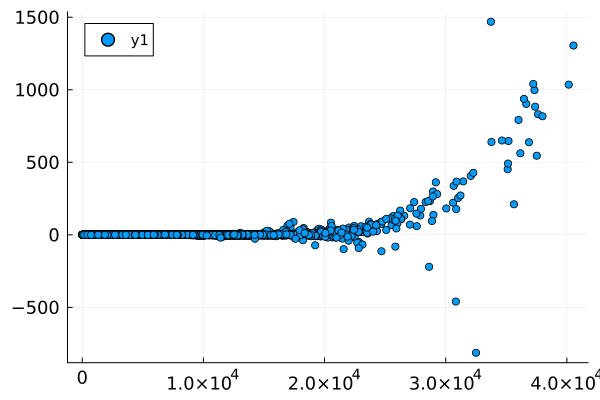

In [10]:
Plots.scatter(energies, residuals,
    linewidth=2,
    legendfontsize=10,
    guidefontsize=14,
    tickfontsize=12,
    titlefontsize=16,
    labelfontsize=14,
)

6048.0

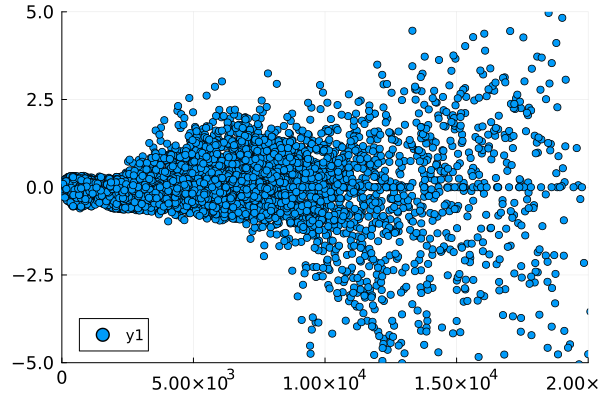

In [11]:
Plots.scatter(energies, residuals,
    linewidth=2,
    legendfontsize=10,
    guidefontsize=14,
    tickfontsize=12,
    titlefontsize=16,
    labelfontsize=14,
    xlimits=(0,20000),
    ylimits=(-5, 5)
)

In [ ]:
residuals = weighted

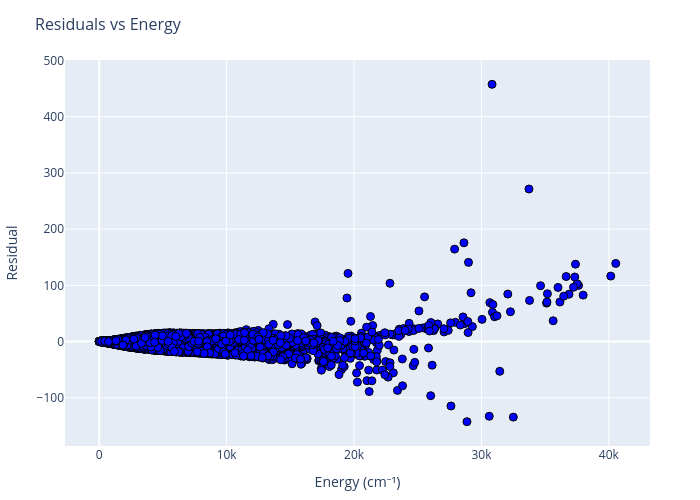

In [171]:
trace = PlotlyJS.scatter(
    x = energies,
    y = residuals,
    mode = "markers",  # for dots only
    marker = attr(
        size = 8,
        color = "blue",
        line = attr(width=1, color="black")
    ),
    name = "Residuals"
)

layout = PlotlyJS.Layout(
    title = attr(text="Residuals vs Energy", font=attr(size=16)),
    xaxis = attr(
        title = attr(text="Energy (cm⁻¹)", font=attr(size=14)),
        # range = [0, 15000],
        tickfont = attr(size=12)
    ),
    yaxis = attr(
        title = attr(text="Residual", font=attr(size=14)),
        tickfont = attr(size=12)
    ),
    legend = attr(font=attr(size=10))
)

PlotlyJS.plot(trace, layout)

In [105]:
structuralParameters
println(numberOfAtoms)
println(numberOfStretches)
println(numberOfBondAngles)
println(numberOfDihedrals)
println(numberOfGridPoints)
println(numberOfLinearParameters)
println(size(grid))
zeros(size(grid))
linearParametersOn
println(length(residuals))

3
2
1
0
6132
162
(6132, 3)
6132


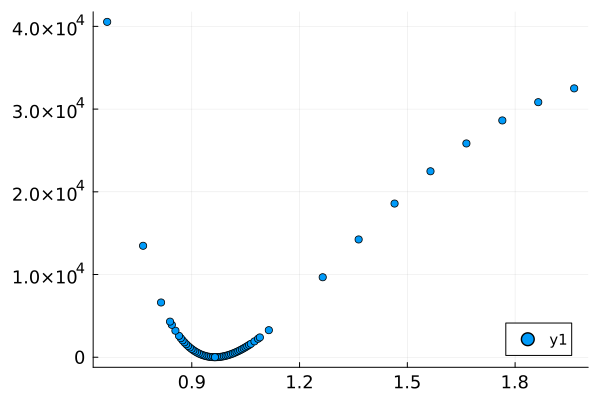

In [211]:
Plots.scatter(grid[1:60], energies[1:60],
    linewidth=2,
    legendfontsize=10,
    guidefontsize=14,
    tickfontsize=12,
    titlefontsize=16,
    labelfontsize=14,
)

In [110]:
xiMatrix

6132×162 Matrix{Float64}:
 1.0       0.0           0.0         …   0.0           0.0
 1.0       0.0           0.0            -0.0           0.0
 1.0       0.0           0.0             0.0           0.0
 1.0       0.0           0.0            -0.0           0.0
 1.0       0.0           0.0             0.0           0.0
 1.0       0.0           0.0         …  -0.0           0.0
 1.0       0.0           0.0             0.0           0.0
 1.0       0.0           0.0            -0.0           0.0
 1.0       0.0           0.0             0.0           0.0
 1.0       0.0           0.0            -0.0           0.0
 ⋮                                   ⋱   ⋮            
 1.0       0.000442598  -9.31137e-6      4.39738e-10   2.68405e-9
 0.99999   0.102324     -0.0327317      -3.70609e-9   -1.01109e-9
 0.999999  0.0661979    -0.017032    …  -6.37204e-8   -6.30735e-8
 0.998854  1.58935e-5   -6.33983e-8     -5.46561e-7    3.89768e-6
 0.984822  0.369534     -0.226362        9.39215e-10  -1.15066e-9

(Ngrid x Nparam) x Nparam = nGrid

In [ ]:
xiMatrix::Matrix{Float64} = zeros(numberOfGridPoints, numberOfLinearParameters)

In [19]:
linearPowers
grid

6132×3 Matrix{Float64}:
 0.964462  1.68888  103.0
 0.959462  1.68888  103.0
 0.969462  1.68888  103.0
 0.954462  1.68888  103.0
 0.974462  1.68888  103.0
 0.949462  1.68888  103.0
 0.979462  1.68888  103.0
 0.944462  1.68888  103.0
 0.984462  1.68888  103.0
 0.939462  1.68888  103.0
 ⋮                  
 0.90976   1.66716  104.24
 0.987089  1.89453  123.013
 1.01684   1.81067  118.832
 1.25891   1.62217  103.235
 0.939755  1.73779  146.878
 0.922218  1.65914  152.591
 1.35633   1.73672   95.7518
 0.982144  1.69171   74.334
 0.907359  1.64528  112.508

In [1]:

# addprocs(4)


# How many MEP parameters for each stretch/bend - order of input file matters!
numberOfParametersRCO::Int64 = sum(occursin.(r"rCO", structuralParameterLabels))
numberOfParametersROH::Int64 = sum(occursin.(r"rOH", structuralParameterLabels))
numberOfParametersRCH::Int64 = sum(occursin.(r"rCH", structuralParameterLabels))
numberOfParametersAHOC::Int64 = sum(occursin.(r"aHOC", structuralParameterLabels))
numberOfParametersAHCO::Int64 = sum(occursin.(r"aHCO", structuralParameterLabels))


# CH3OH
function potentialEnergy(internalCoordinates::Vector{Float64}, parameters::Vector{Float64})::Float64
    # Obtain MEP parameters for each stretch and bend
    parameterLowerRange::Int64 = 1
    parameterUpperRange::Int64 = numberOfParametersRCO
    # powersRCO::Matrix{Float64} = structuralPowers[1:parameterUpperRange, :]
    # parametersRCO::Vector{Float64} = parameters[1:parameterUpperRange]
    rCOeq::Float64 = obtainCoordinateMEP(internalCoordinates[end], structuralPowers[1:parameterUpperRange,:], parameters[1:parameterUpperRange])
    parameterUpperRange += numberOfParametersROH
    parameterLowerRange += numberOfParametersRCO
    # powersROH::Matrix{Float64} = structuralPowers[parameterLowerRange:parameterUpperRange,:]
    # parametersROH::Vector{Float64} = parameters[parameterLowerRange:parameterUpperRange]
    rOHeq::Float64 = obtainCoordinateMEP(internalCoordinates[end], structuralPowers[parameterLowerRange:parameterUpperRange,:], parameters[parameterLowerRange:parameterUpperRange])
    parameterUpperRange += numberOfParametersRCH
    parameterLowerRange += numberOfParametersROH
    # powersRCH::Matrix{Float64} = structuralPowers[parameterLowerRange:parameterUpperRange,:]
    # parametersRCH::Vector{Float64} = parameters[parameterLowerRange:parameterUpperRange]
    rCH1eq::Float64 = obtainCoordinateMEP(internalCoordinates[end], structuralPowers[parameterLowerRange:parameterUpperRange,:], parameters[parameterLowerRange:parameterUpperRange])
    rCH2eq::Float64 = obtainCoordinateMEP(internalCoordinates[end] + 2*pi/3, structuralPowers[parameterLowerRange:parameterUpperRange,:], parameters[parameterLowerRange:parameterUpperRange])
    rCH3eq::Float64 = obtainCoordinateMEP(internalCoordinates[end] + 4*pi/3, structuralPowers[parameterLowerRange:parameterUpperRange,:], parameters[parameterLowerRange:parameterUpperRange])
    parameterUpperRange += numberOfParametersAHOC
    parameterLowerRange += numberOfParametersRCH
    # powersAHOC::Matrix{Float64} = structuralPowers[parameterLowerRange:parameterUpperRange,:]
    # parametersAHOC::Vector{Float64} = parameters[parameterLowerRange:parameterUpperRange]
    aHOCeq::Float64 = obtainCoordinateMEP(internalCoordinates[end], structuralPowers[parameterLowerRange:parameterUpperRange,:], parameters[parameterLowerRange:parameterUpperRange])
    parameterUpperRange += numberOfParametersAHCO
    parameterLowerRange += numberOfParametersAHOC
    # powersAHCO::Matrix{Float64} = structuralPowers[parameterLowerRange:parameterUpperRange,:]
    # parametersAHCO::Vector{Float64} = parameters[parameterLowerRange:parameterUpperRange]
    aHCO1eq::Float64 = obtainCoordinateMEP(internalCoordinates[end], structuralPowers[parameterLowerRange:parameterUpperRange,:], parameters[parameterLowerRange:parameterUpperRange])
    aHCO2eq::Float64 = obtainCoordinateMEP(internalCoordinates[end] + 2*pi/3, structuralPowers[parameterLowerRange:parameterUpperRange,:], parameters[parameterLowerRange:parameterUpperRange])
    aHCO3eq::Float64 = obtainCoordinateMEP(internalCoordinates[end] + 4*pi/3, structuralPowers[parameterLowerRange:parameterUpperRange,:], parameters[parameterLowerRange:parameterUpperRange])
    parameterLowerRange += numberOfParametersAHCO
    morseParameters::Vector{Float64} = parameters[parameterLowerRange:parameterLowerRange + numberOfMorseParameters - 1]

    # println(rCOeq)
    # println(rOHeq)
    # println(rCH1eq)
    # println(rCH2eq)
    # println(rCH3eq)
    # println(aHOCeq)
    # println(aHCO1eq)
    # println(aHCO2eq)
    # println(aHCO3eq)

    xi::Vector{Float64} = zeros(numberOfModes - 1)
    # Stretches
    xi[1] = 1 - exp(-morseParameters[1]*(internalCoordinates[1] - rCOeq))
    xi[2] = 1 - exp(-morseParameters[2]*(internalCoordinates[2] - rOHeq))
    xi[3] = 1 - exp(-morseParameters[3]*(internalCoordinates[3] - rCH1eq))
    xi[4] = 1 - exp(-morseParameters[3]*(internalCoordinates[4] - rCH2eq))
    xi[5] = 1 - exp(-morseParameters[3]*(internalCoordinates[5] - rCH3eq))

    # Bending
    xi[6] = (internalCoordinates[6] - aHOCeq)*convertToRadians
    xi[7] = (internalCoordinates[7] - aHCO1eq)*convertToRadians
    xi[8] = (internalCoordinates[8] - aHCO2eq)*convertToRadians
    xi[9] = (internalCoordinates[9] - aHCO3eq)*convertToRadians

    # Dihedrals
    xi[10] = internalCoordinates[10]
    xi[11] = internalCoordinates[11]
    
    parameterLowerRange += numberOfMorseParameters
    parameterUpperRange = size(parameters)[1]
    
    symmetryOperations::Array{Float64} = defineSymmetryOperations()
    numberOfSymmetryOperations::Int64 = size(symmetryOperations)[1]

    potential::Float64 = 0.0

    for i in 1:numberOfSymmetryOperations
        tau::Float64 = symmetryOperationsTau[i](internalCoordinates[12])
        xiTransformed::Vector{Float64} = symmetryOperations[i, :, :]*xi
        for j in parameterLowerRange:parameterUpperRange
            if linearPowers[j - parameterLowerRange + 1, end] >= 0
                potential += cos(linearPowers[j - parameterLowerRange + 1, end]*tau)*prod(xiTransformed.^linearPowers[j - parameterLowerRange + 1, 1:end-1])*parameters[j]
            else
                potential += sin(-linearPowers[j - parameterLowerRange + 1, end]*tau)*prod(xiTransformed.^linearPowers[j - parameterLowerRange + 1, 1:end-1])*parameters[j]
            end
        end
    end
    potential /= 6
end

# Here we define a function which ensures parameters not currently in the fit are unchanged
function potentialEnergyOfGrid(gridInternalCoordinates::Matrix{Float64}, parameters::Vector{Float64})::Vector{Float64}
    # parameters = [allParametersOn[i] == 1 ? parameters[i] : allParameters[i] for i in 1:length(allParametersOn)]
    numberOfPoints::Int64 = size(gridInternalCoordinates)[1]
    predictedEnergies::Vector{Float64} = zeros(numberOfPoints)
    for i in 1:numberOfPoints
        predictedEnergies[i] = potentialEnergy(gridInternalCoordinates[i, :], parameters)
    end
    return predictedEnergies
end

function lossGrid(parameters::Vector{Float64}, gridInternalCoordinates::Matrix{Float64}, energies::Vector{Float64}, weights::Vector{Float64})::Float64
    predictedEnergies::Vector{Float64} = potentialEnergyOfGrid(gridInternalCoordinates::Matrix{Float64}, parameters::Vector{Float64})
    residuals::Vector{Float64} = energies - predictedEnergies
    return sum(weights .*abs2.(predictedEnergies))
end

function computeJacobianAtPoint(internalCoordinates::Vector{Float64}, parameters::Vector{Float64})::Vector{Float64}
    numberOfParameters::Int64 = length(parameters)
    derivatives::Vector{Float64} = zeros(numberOfParameters)
    
    # Obtain MEP parameters for each stretch and bend
    parameterLowerRange::Int64 = 1
    parameterUpperRange::Int64 = numberOfParametersRCO
    powersRCO::Matrix{Int64} = structuralPowers[1:parameterUpperRange, :]
    parametersRCO::Vector{Float64} = parameters[1:parameterUpperRange]
    rCOeq::Float64 = obtainCoordinateMEP(internalCoordinates[end], structuralPowers[1:parameterUpperRange,:], parameters[1:parameterUpperRange])
    parameterUpperRange += numberOfParametersROH
    parameterLowerRange += numberOfParametersRCO
    powersROH::Matrix{Int64} = structuralPowers[parameterLowerRange:parameterUpperRange,:]
    parametersROH::Vector{Float64} = parameters[parameterLowerRange:parameterUpperRange]
    rOHeq::Float64 = obtainCoordinateMEP(internalCoordinates[end], structuralPowers[parameterLowerRange:parameterUpperRange,:], parameters[parameterLowerRange:parameterUpperRange])
    parameterUpperRange += numberOfParametersRCH
    parameterLowerRange += numberOfParametersROH
    powersRCH::Matrix{Int64} = structuralPowers[parameterLowerRange:parameterUpperRange,:]
    parametersRCH::Vector{Float64} = parameters[parameterLowerRange:parameterUpperRange]
    rCH1eq::Float64 = obtainCoordinateMEP(internalCoordinates[end], structuralPowers[parameterLowerRange:parameterUpperRange,:], parameters[parameterLowerRange:parameterUpperRange])
    rCH2eq::Float64 = obtainCoordinateMEP(internalCoordinates[end] + 2*pi/3, structuralPowers[parameterLowerRange:parameterUpperRange,:], parameters[parameterLowerRange:parameterUpperRange])
    rCH3eq::Float64 = obtainCoordinateMEP(internalCoordinates[end] + 4*pi/3, structuralPowers[parameterLowerRange:parameterUpperRange,:], parameters[parameterLowerRange:parameterUpperRange])
    parameterUpperRange += numberOfParametersAHOC
    parameterLowerRange += numberOfParametersRCH
    powersAHOC::Matrix{Int64} = structuralPowers[parameterLowerRange:parameterUpperRange,:]
    parametersAHOC::Vector{Float64} = parameters[parameterLowerRange:parameterUpperRange]
    aHOCeq::Float64 = obtainCoordinateMEP(internalCoordinates[end], structuralPowers[parameterLowerRange:parameterUpperRange,:], parameters[parameterLowerRange:parameterUpperRange])
    parameterUpperRange += numberOfParametersAHCO
    parameterLowerRange += numberOfParametersAHOC
    powersAHCO::Matrix{Int64} = structuralPowers[parameterLowerRange:parameterUpperRange,:]
    parametersAHCO::Vector{Float64} = parameters[parameterLowerRange:parameterUpperRange]
    aHCO1eq::Float64 = obtainCoordinateMEP(internalCoordinates[end], structuralPowers[parameterLowerRange:parameterUpperRange,:], parameters[parameterLowerRange:parameterUpperRange])
    aHCO2eq::Float64 = obtainCoordinateMEP(internalCoordinates[end] + 2*pi/3, structuralPowers[parameterLowerRange:parameterUpperRange,:], parameters[parameterLowerRange:parameterUpperRange])
    aHCO3eq::Float64 = obtainCoordinateMEP(internalCoordinates[end] + 4*pi/3, structuralPowers[parameterLowerRange:parameterUpperRange,:], parameters[parameterLowerRange:parameterUpperRange])
    parameterLowerRange += numberOfParametersAHCO
    morseParameters::Vector{Float64} = parameters[parameterLowerRange:parameterLowerRange + numberOfMorseParameters - 1]

    # println(rCOeq)
    # println(rOHeq)
    # println(rCH1eq)
    # println(rCH2eq)
    # println(rCH3eq)
    # println(aHOCeq)
    # println(aHCO1eq)
    # println(aHCO2eq)
    # println(aHCO3eq)

    xi::Vector{Float64} = zeros(numberOfModes - 1)
    # Stretches
    xi[1] = 1 - exp(-morseParameters[1]*(internalCoordinates[1] - rCOeq))
    xi[2] = 1 - exp(-morseParameters[2]*(internalCoordinates[2] - rOHeq))
    xi[3] = 1 - exp(-morseParameters[3]*(internalCoordinates[3] - rCH1eq))
    xi[4] = 1 - exp(-morseParameters[3]*(internalCoordinates[4] - rCH2eq))
    xi[5] = 1 - exp(-morseParameters[3]*(internalCoordinates[5] - rCH3eq))

    # Bending
    xi[6] = (internalCoordinates[6] - aHOCeq)*convertToRadians
    xi[7] = (internalCoordinates[7] - aHCO1eq)*convertToRadians
    xi[8] = (internalCoordinates[8] - aHCO2eq)*convertToRadians
    xi[9] = (internalCoordinates[9] - aHCO3eq)*convertToRadians

    # Dihedrals
    xi[10] = internalCoordinates[10]
    xi[11] = internalCoordinates[11]
    
    parameterLowerRange += numberOfMorseParameters
    parameterUpperRange = size(parameters)[1]
    
    symmetryOperations::Array{Float64} = defineSymmetryOperations()
    numberOfSymmetryOperations::Int64 = size(symmetryOperations)[1]

    for i in 1:numberOfSymmetryOperations
        xiTransformed::Vector{Float64} = symmetryOperations[i, :, :]*xi
        internalCoordinatesTransformed::Vector{Float64} = symmetryOperations[i, :, :]*internalCoordinates[1:end-1]
        tau::Float64 = symmetryOperationsTau[i](internalCoordinates[12])
        # Derivatives of CO MEP parameters
        for j in 1:numberOfParametersRCO
            if allParametersOn[j] == 1
                for k in parameterLowerRange:parameterUpperRange
                    newTerm::Float64 = 0
                    if linearPowers[k - parameterLowerRange + 1, 1] == 0
                        continue
                    end
                    if powersRCO[j, end] >= 0
                        newTerm += -morseParameters[1]*linearPowers[k - parameterLowerRange + 1, 1]*exp(-morseParameters[1]*(internalCoordinatesTransformed[1] - obtainCoordinateMEP(tau, powersRCO, parametersRCO)))*xiTransformed[1]^(linearPowers[k - parameterLowerRange + 1, 1] - 1)*prod(xiTransformed[2:end].^linearPowers[k - parameterLowerRange + 1, 2:end-1])*cos(powersRCO[j, end]*tau)
                    else
                        newTerm += -morseParameters[1]*linearPowers[k - parameterLowerRange + 1, 1]*exp(-morseParameters[1]*(internalCoordinatesTransformed[1] - obtainCoordinateMEP(tau, powersRCO, parametersRCO)))*xiTransformed[1]^(linearPowers[k - parameterLowerRange + 1, 1] - 1)*prod(xiTransformed[2:end].^linearPowers[k - parameterLowerRange + 1, 2:end-1])*sin(-powersRCO[j, end]*tau)
                    end
                    if linearPowers[k - parameterLowerRange + 1, end] >= 0
                        newTerm *= cos(tau*linearPowers[k - parameterLowerRange + 1, end])
                    else
                        newTerm *= sin(-tau*linearPowers[k - parameterLowerRange + 1, end])
                    end
                    derivatives[j] += newTerm*parameters[k] 
                end
            end
        end
        # Derivatives of OH MEP parameters
        for j in 1:numberOfParametersROH
            if allParametersOn[j + numberOfParametersRCO] == 1
                for k in parameterLowerRange:parameterUpperRange
                    newTerm::Float64 = 0
                    if linearPowers[k - parameterLowerRange + 1, 2] == 0
                        continue
                    end
                    if powersROH[j, end] >= 0
                        newTerm += -morseParameters[2]*linearPowers[k - parameterLowerRange + 1, 2]*exp(-morseParameters[2]*(internalCoordinatesTransformed[2] - obtainCoordinateMEP(tau, powersROH, parametersROH)))*xiTransformed[2]^(linearPowers[k - parameterLowerRange + 1, 2] - 1)*xiTransformed[1]^linearPowers[k - parameterLowerRange + 1, 1]*prod(xiTransformed[3:end].^linearPowers[k - parameterLowerRange + 1, 3:end-1])*cos(powersROH[j, end]*tau)
                    else
                        newTerm += -morseParameters[2]*linearPowers[k - parameterLowerRange + 1, 2]*exp(-morseParameters[2]*(internalCoordinatesTransformed[2] - obtainCoordinateMEP(tau, powersROH, parametersROH)))*xiTransformed[2]^(linearPowers[k - parameterLowerRange + 1, 2] - 1)*xiTransformed[1]^linearPowers[k - parameterLowerRange + 1, 1]*prod(xiTransformed[3:end].^linearPowers[k - parameterLowerRange + 1, 3:end-1])*sin(-powersROH[j, end]*tau)
                    end
                    if linearPowers[k - parameterLowerRange + 1, end] >= 0
                        newTerm *= cos(tau*linearPowers[k - parameterLowerRange + 1, end])
                    else
                        newTerm *= sin(-tau*linearPowers[k - parameterLowerRange + 1, end])
                    end
                    derivatives[j + numberOfParametersRCO] += newTerm*parameters[k]  
                end
            end
        end
        # Derivatives of CH MEP parameters
        for j in 1:numberOfParametersRCH
            if allParametersOn[j + numberOfParametersRCO + numberOfParametersROH] == 1
                for k in parameterLowerRange:parameterUpperRange
                    newTerm::Float64 = 0
                    if powersROH[j, end] >= 0
                        if linearPowers[k - parameterLowerRange + 1, 3] > 0
                            newTerm += -morseParameters[3]*linearPowers[k - parameterLowerRange + 1, 3]*exp(-morseParameters[3]*(internalCoordinatesTransformed[3] - obtainCoordinateMEP(tau, powersRCH, parametersRCH)))*xiTransformed[3]^(linearPowers[k - parameterLowerRange + 1, 3] - 1)*prod(xiTransformed[1:2].^linearPowers[k - parameterLowerRange + 1, 1:2])*prod(xiTransformed[4:end].^linearPowers[k - parameterLowerRange + 1, 4:end-1])*cos(powersRCH[j, end]*tau)
                        end
                        if linearPowers[k - parameterLowerRange + 1, 4] > 0
                            newTerm += -morseParameters[3]*linearPowers[k - parameterLowerRange + 1, 4]*exp(-morseParameters[3]*(internalCoordinatesTransformed[4] - obtainCoordinateMEP(tau, powersRCH, parametersRCH + 2*pi/3)))*xiTransformed[4]^(linearPowers[k - parameterLowerRange + 1, 4] - 1)*prod(xiTransformed[1:3].^linearPowers[k - parameterLowerRange + 1, 1:3])*prod(xiTransformed[5:end].^linearPowers[k - parameterLowerRange + 1, 5:end-1])*cos(powersRCH[j, end]*(tau + 2*pi/3))
                        end
                        if linearPowers[k - parameterLowerRange + 1, 5] > 0
                            newTerm += -morseParameters[3]*linearPowers[k - parameterLowerRange + 1, 5]*exp(-morseParameters[3]*(internalCoordinatesTransformed[5] - obtainCoordinateMEP(tau, powersRCH, parametersRCH + 4*pi/3)))*xiTransformed[5]^(linearPowers[k - parameterLowerRange + 1, 5] - 1)*prod(xiTransformed[1:4].^linearPowers[k - parameterLowerRange + 1, 1:4])*prod(xiTransformed[6:end].^linearPowers[k - parameterLowerRange + 1, 6:end-1])*cos(powersRCH[j, end]*(tau + 4*pi/3))
                        end
                    else
                        if linearPowers[k - parameterLowerRange + 1, 3] > 0
                            newTerm += -morseParameters[3]*linearPowers[k - parameterLowerRange + 1, 3]*exp(-morseParameters[3]*(internalCoordinatesTransformed[3] - obtainCoordinateMEP(tau, powersRCH, parametersRCH)))*xiTransformed[3]^(linearPowers[k - parameterLowerRange + 1, 3] - 1)*prod(xiTransformed[1:2].^linearPowers[k - parameterLowerRange + 1, 1:2])*prod(xiTransformed[4:end].^linearPowers[k - parameterLowerRange + 1, 4:end-1])*sin(-powersRCH[j, end]*tau)
                        end
                        if linearPowers[k - parameterLowerRange + 1, 4] > 0
                            newTerm += -morseParameters[3]*linearPowers[k - parameterLowerRange + 1, 4]*exp(-morseParameters[3]*(internalCoordinatesTransformed[4] - obtainCoordinateMEP(tau, powersRCH, parametersRCH + 2*pi/3)))*xiTransformed[4]^(linearPowers[k - parameterLowerRange + 1, 4] - 1)*prod(xiTransformed[1:3].^linearPowers[k - parameterLowerRange + 1, 1:3])*prod(xiTransformed[5:end].^linearPowers[k - parameterLowerRange + 1, 5:end-1])*sin(-powersRCH[j, end]*(tau + 2*pi/3))
                        end
                        if linearPowers[k - parameterLowerRange + 1, 5] > 0
                            newTerm += -morseParameters[3]*linearPowers[k - parameterLowerRange + 1, 5]*exp(-morseParameters[3]*(internalCoordinatesTransformed[5] - obtainCoordinateMEP(tau, powersRCH, parametersRCH + 4*pi/3)))*xiTransformed[5]^(linearPowers[k - parameterLowerRange + 1, 5] - 1)*prod(xiTransformed[1:4].^linearPowers[k - parameterLowerRange + 1, 1:4])*prod(xiTransformed[6:end].^linearPowers[k - parameterLowerRange + 1, 6:end-1])*sin(-powersRCH[j, end]*(tau + 4*pi/3))
                        end
                    end
                    if linearPowers[k - parameterLowerRange + 1, end] >= 0
                        newTerm *= cos(tau*linearPowers[k - parameterLowerRange + 1, end])
                    else
                        newTerm *= sin(-tau*linearPowers[k - parameterLowerRange + 1, end])
                    end
                    derivatives[j + numberOfParametersRCO + numberOfParametersROH] += newTerm*parameters[k]
                end
            end
        end
        # Derivatives of aHOC MEP parameters
        for j in 1:numberOfParametersAHOC
            if allParametersOn[j + numberOfParametersRCO + numberOfParametersROH + numberOfParametersRCH] == 1
                for k in parameterLowerRange:parameterUpperRange
                    newTerm::Float64 = 0
                    if linearPowers[k - parameterLowerRange + 1, 6] == 0
                        continue
                    end
                    if powersROH[j, end] >= 0
                        newTerm += -linearPowers[k - parameterLowerRange + 1, 6]*xiTransformed[6]^(linearPowers[k - parameterLowerRange + 1, 6] - 1)*prod(xiTransformed[1:5].^linearPowers[k - parameterLowerRange + 1, 1:5])*prod(xiTransformed[7:end].^linearPowers[k - parameterLowerRange + 1, 7:end-1])*cos(powersAHOC[j, end]*tau)
                    else
                        newTerm += -linearPowers[k - parameterLowerRange + 1, 6]*xiTransformed[6]^(linearPowers[k - parameterLowerRange + 1, 6] - 1)*prod(xiTransformed[1:5].^linearPowers[k - parameterLowerRange + 1, 1:5])*prod(xiTransformed[7:end].^linearPowers[k - parameterLowerRange + 1, 7:end-1])*sin(-powersAHOC[j, end]*tau)
                    end
                    if linearPowers[k - parameterLowerRange + 1, end] >= 0
                        newTerm *= cos(tau*linearPowers[k - parameterLowerRange + 1, end])
                    else
                        newTerm *= sin(-tau*linearPowers[k - parameterLowerRange + 1, end])
                    end
                    derivatives[j + numberOfParametersRCO + numberOfParametersROH + numberOfParametersRCH] += newTerm*parameters[k]
                end
            end
        end
        # Derivatives of aHCO MEP parameters
        for j in 1:numberOfParametersAHCO
            if allParametersOn[j + numberOfParametersRCO + numberOfParametersROH + numberOfParametersRCH + numberOfParametersAHOC] == 1
                for k in parameterLowerRange:parameterUpperRange
                    newTerm::Float64 = 0
                    if powersROH[j, end] >= 0
                        if linearPowers[k - parameterLowerRange + 1, 7] > 0
                            newTerm += -linearPowers[k - parameterLowerRange + 1, 7]*xiTransformed[7]^(linearPowers[k - parameterLowerRange + 1, 7] - 1)*prod(xiTransformed[1:6].^linearPowers[k - parameterLowerRange + 1, 1:6])*prod(xiTransformed[8:end].^linearPowers[k - parameterLowerRange + 1, 8:end-1])*cos(powersAHCO[j, end]*tau)
                        end
                        if linearPowers[k - parameterLowerRange + 1, 8] > 0
                            newTerm += -linearPowers[k - parameterLowerRange + 1, 8]*xiTransformed[8]^(linearPowers[k - parameterLowerRange + 1, 8] - 1)*prod(xiTransformed[1:7].^linearPowers[k - parameterLowerRange + 1, 1:7])*prod(xiTransformed[9:end].^linearPowers[k - parameterLowerRange + 1, 9:end-1])*cos(powersAHCO[j, end]*(tau + 2*pi/3))
                        end
                        if linearPowers[k - parameterLowerRange + 1, 9] > 0
                            newTerm += -linearPowers[k - parameterLowerRange + 1, 9]*xiTransformed[9]^(linearPowers[k - parameterLowerRange + 1, 9] - 1)*prod(xiTransformed[1:8].^linearPowers[k - parameterLowerRange + 1, 1:8])*prod(xiTransformed[10:end].^linearPowers[k - parameterLowerRange + 1, 10:end-1])*cos(powersAHCO[j, end]*(tau + 4*pi/3))
                        end
                    else
                        if linearPowers[k - parameterLowerRange + 1, 7] > 0
                            newTerm += -linearPowers[k - parameterLowerRange + 1, 7]*xiTransformed[7]^(linearPowers[k - parameterLowerRange + 1, 7] - 1)*prod(xiTransformed[1:6].^linearPowers[k - parameterLowerRange + 1, 1:6])*prod(xiTransformed[8:end].^linearPowers[k - parameterLowerRange + 1, 8:end-1])*sin(-powersAHCO[j, end]*tau)
                        end
                        if linearPowers[k - parameterLowerRange + 1, 8] > 0
                            newTerm += -linearPowers[k - parameterLowerRange + 1, 8]*xiTransformed[8]^(linearPowers[k - parameterLowerRange + 1, 8] - 1)*prod(xiTransformed[1:7].^linearPowers[k - parameterLowerRange + 1, 1:7])*prod(xiTransformed[9:end].^linearPowers[k - parameterLowerRange + 1, 9:end-1])*sin(-powersAHCO[j, end]*(tau + 2*pi/3))
                        end
                        if linearPowers[k - parameterLowerRange + 1, 9] > 0
                            newTerm += -linearPowers[k - parameterLowerRange + 1, 9]*xiTransformed[9]^(linearPowers[k - parameterLowerRange + 1, 9] - 1)*prod(xiTransformed[1:8].^linearPowers[k - parameterLowerRange + 1, 1:8])*prod(xiTransformed[10:end].^linearPowers[k - parameterLowerRange + 1, 10:end-1])*sin(-powersAHCO[j, end]*(tau + 4*pi/3))
                        end
                    end
                    if linearPowers[k - parameterLowerRange + 1, end] >= 0
                        newTerm *= cos(tau*linearPowers[k - parameterLowerRange + 1, end])
                    else
                        newTerm *= sin(-tau*linearPowers[k - parameterLowerRange + 1, end])
                    end
                    derivatives[j + numberOfParametersRCO + numberOfParametersROH + numberOfParametersRCH + numberOfParametersAHOC] += newTerm*parameters[k]
                end
            end
        end
        # Derivatives of morse parameters
        # rCO
        if allParametersOn[parameterLowerRange - 3] == 1
            for k in parameterLowerRange:parameterUpperRange
                newTerm::Float64 = 0
                if linearPowers[k - parameterLowerRange + 1, 1] == 0
                    continue
                end
                newTerm += linearPowers[k - parameterLowerRange + 1, 1]*exp(-morseParameters[1]*(internalCoordinatesTransformed[1] - obtainCoordinateMEP(tau, powersRCO, parametersRCO)))*(internalCoordinatesTransformed[1] - obtainCoordinateMEP(tau, powersRCO, parametersRCO))*xiTransformed[1]^(linearPowers[k - parameterLowerRange + 1, 1] - 1)*prod(xiTransformed[2:end].^linearPowers[k - parameterLowerRange + 1, 2:end-1])
                if linearPowers[k - parameterLowerRange + 1, end] >= 0
                    newTerm *= cos(tau*linearPowers[k - parameterLowerRange + 1, end])
                else
                    newTerm *= sin(-tau*linearPowers[k - parameterLowerRange + 1, end])
                end
                derivatives[parameterLowerRange - 3] += newTerm*parameters[k] 
            end
        end
        # rOH
        if allParametersOn[parameterLowerRange - 2] == 1
            for k in parameterLowerRange:parameterUpperRange
                newTerm::Float64 = 0
                if linearPowers[k - parameterLowerRange + 1, 2] == 0
                    continue
                end
                newTerm += linearPowers[k - parameterLowerRange + 1, 2]*exp(-morseParameters[2]*(internalCoordinatesTransformed[1] - obtainCoordinateMEP(tau, powersROH, parametersROH)))*(internalCoordinatesTransformed[1] - obtainCoordinateMEP(tau, powersRCO, parametersRCO))*xiTransformed[2]^(linearPowers[k - parameterLowerRange + 1, 2] - 1)*prod(xiTransformed[3:end].^linearPowers[k - parameterLowerRange + 1, 3:end-1])*xiTransformed[1]^linearPowers[k - parameterLowerRange + 1, 1]
                if linearPowers[k - parameterLowerRange + 1, end] >= 0
                    newTerm *= cos(tau*linearPowers[k - parameterLowerRange + 1, end])
                else
                    newTerm *= sin(-tau*linearPowers[k - parameterLowerRange + 1, end])
                end
                derivatives[parameterLowerRange - 2] += newTerm*parameters[k] 
            end
        end
        # rCH
        if allParametersOn[parameterLowerRange - 1] == 1
            for k in parameterLowerRange:parameterUpperRange
                newTerm::Float64 = 0
                if linearPowers[k - parameterLowerRange + 1, 3] > 0
                    newTerm += linearPowers[k - parameterLowerRange + 1, 3]*exp(-morseParameters[3]*(internalCoordinatesTransformed[3] - obtainCoordinateMEP(tau, powersRCH, parametersRCH)))*(internalCoordinatesTransformed[3] - obtainCoordinateMEP(tau, powersRCH, parametersRCH))*xiTransformed[3]^(linearPowers[k - parameterLowerRange + 1, 3] - 1)*prod(xiTransformed[1:2].^linearPowers[k - parameterLowerRange + 1, 1:2])*prod(xiTransformed[4:end].^linearPowers[k - parameterLowerRange + 1, 4:end-1])
                end
                if linearPowers[k - parameterLowerRange + 1, 4] > 0
                    newTerm += linearPowers[k - parameterLowerRange + 1, 4]*exp(-morseParameters[3]*(internalCoordinatesTransformed[4] - obtainCoordinateMEP(tau, powersRCH, parametersRCH + 2*pi/3)))*(internalCoordinatesTransformed[4] - obtainCoordinateMEP(tau, powersRCH, parametersRCH + 2*pi/3))*xiTransformed[4]^(linearPowers[k - parameterLowerRange + 1, 4] - 1)*prod(xiTransformed[1:3].^linearPowers[k - parameterLowerRange + 1, 1:3])*prod(xiTransformed[5:end].^linearPowers[k - parameterLowerRange + 1, 5:end-1])
                end
                if linearPowers[k - parameterLowerRange + 1, 5] > 0
                    newTerm += linearPowers[k - parameterLowerRange + 1, 5]*exp(-morseParameters[3]*(internalCoordinatesTransformed[5] - obtainCoordinateMEP(tau, powersRCH, parametersRCH + 4*pi/3)))*(internalCoordinatesTransformed[5] - obtainCoordinateMEP(tau, powersRCH, parametersRCH + 4*pi/3))*xiTransformed[5]^(linearPowers[k - parameterLowerRange + 1, 5] - 1)*prod(xiTransformed[1:4].^linearPowers[k - parameterLowerRange + 1, 1:4])*prod(xiTransformed[6:end].^linearPowers[k - parameterLowerRange + 1, 6:end-1])
                end
                if linearPowers[k - parameterLowerRange + 1, end] >= 0
                    newTerm *= cos(tau*linearPowers[k - parameterLowerRange + 1, end])
                else
                    newTerm *= sin(-tau*linearPowers[k - parameterLowerRange + 1, end])
                end
                derivatives[parameterLowerRange - 1] += newTerm*parameters[k]
            end
        end
        # Derivatives of linear parameters
        for j in parameterLowerRange:parameterUpperRange
            if allParametersOn[j] == 1
                if linearPowers[j - parameterLowerRange + 1, end] >= 0
                    derivatives[j] += cos(linearPowers[j - parameterLowerRange + 1, end]*tau)*prod(xiTransformed.^linearPowers[j - parameterLowerRange + 1, 1:end-1])
                else
                    derivatives[j] += sin(-linearPowers[j - parameterLowerRange + 1, end]*tau)*prod(xiTransformed.^linearPowers[j - parameterLowerRange + 1, 1:end-1])
                end
            end
        end
    end
    derivatives ./= 6
end

function computeJacobianOnGrid(gridInternalCoordinates::Matrix{Float64}, parameters::Vector{Float64})::Matrix{Float64}
    numberOfGridPoints::Int64 = size(gridInternalCoordinates)[1]
    numberOfParameters::Int64 = length(parameters)
    jacobian::Matrix{Float64} = zeros(numberOfGridPoints, numberOfParameters)
    for i in 1:numberOfGridPoints
        jacobian[i, :] = computeJacobianAtPoint(gridInternalCoordinates[i, :], parameters)
    end
    return jacobian
end

function computeJacobianOnLossGrid(parameters::Vector{Float64}, gridInternalCoordinates::Matrix{Float64}, energies::Vector{Float64}, weights::Vector{Float64})::Matrix{Float64}
    numberOfGridPoints::Int64 = size(gridInternalCoordinates)[1]
    numberOfParameters::Int64 = length(parameters)
    weightedResiduals::Vector{Float64} = 2*weights.*(energies .- lossGrid(allParameters, gridInternalCoordinates, energies, weights))
    jacobian::Matrix{Float64} = zeros(numberOfGridPoints, numberOfParameters)
    for i in 1:numberOfGridPoints
        jacobian[i, :] = weightedResiduals[i]*computeJacobianAtPoint(gridInternalCoordinates[i, :], parameters)
    end
    return jacobian
end

# @time res = optimize(allParameters -> lossGrid(allParameters, gridInternalCoordinates, energies, weights), allParameters -> computeJacobianOnLossGrid(allParameters, gridInternalCoordinates, energies, weights), allParameters, BFGS()) 
# newParams = Optim.minimizer(res)


@time fittedPotentialEnergy = curve_fit(potentialEnergyOfGrid, computeJacobianOnGrid, gridInternalCoordinates, energies, weights, allParameters)

fittedParameters::Vector{Float64} = fittedPotentialEnergy.param
computedEnergies::Vector{Float64} = potentialEnergyOfGrid(gridInternalCoordinates, fittedParameters)
residuals::Vector{Float64} = energies .- computedEnergies

open(inputFileName*".out", "w") do outputFile::IOStream
    println(outputFile, "New model:")
    for i in 1:numberOfParameters
        @printf(outputFile, "%4.0f %4.0f %4.0f %4.0f %4.0f %4.0f %4.0f %4.0f %4.0f %4.0f %4.0f %4.0f %12.8f\n", allPowers[i, 1], allPowers[i, 2], allPowers[i, 3], allPowers[i, 4], allPowers[i, 5], allPowers[i, 6], allPowers[i, 7], allPowers[i, 8], allPowers[i, 9], allPowers[i, 10], allPowers[i, 11], allPowers[i, 12], fittedParameters[i])
    end
    println(outputFile, )
    println(outputFile, "Grid of energies:")
    for i in 1:numberOfGridPoints
        @printf(outputFile, "%12.8f %12.8f %12.8f %12.8f %12.8f %12.8f %12.8f %12.8f %12.8f %12.8f %12.8f %12.8f %12.8f %12.8f %12.8f\n", grid[i, 1], grid[i, 2], grid[i, 3], grid[i, 4], grid[i, 5], grid[i, 6], grid[i, 7], grid[i, 8], grid[i, 9], grid[i, 10], grid[i, 11], grid[i, 12], energies[i], computedEnergies[i], residuals[i])
    end
end

SystemError: SystemError: opening file "/home/oleksiy_smola/Projects/HOCL/Potential/CH3OH.jl": No such file or directory

In [7]:
# @time result = curve_fit(potentialEnergyModel, gridValenceCoordinates, energies, structuralParameters)

# learningRate::Float64 = 0.1
# epochs::Int64 = 50
# for epoch in 1:epochs
#     residuals::Vector{Float64} = normalizedXiMatrix*linearParameters .- energies
#     weights = computeWeightOfPoint.(energies)./(residuals.^2 .+ ϵ)
#     weightsSqrt = sqrt.(weights)
#     println("Epoch $(epoch - 1), Loss = ", sum(weights.*residuals.^2)/numberOfGridPoints)
#     Q, R = qr(Diagonal(weightsSqrt)*normalizedXiMatrix) 
#     linearParameters = R \ (Matrix(Q)' * (energies.*weightsSqrt))
#     # linearParameters = normalizedXiMatrix.*weightsSqrt \ (energies.*weightsSqrt)
# end
# for epoch in 1:epochs
#     for (gridBatch, energyBatch, weightBatch) in getBatches(gridValenceCoordinates, energies, weights, batchSize)
#         xiMatrixBatch::Matrix{Float64} = generateXiMatrix(gridBatch, structuralParametersConverted)
#         # xiMatrixBatch = (xiMatrixBatch .- normalizationMeans')./normalizationStandardDeviation'
#         gradientVector::Vector{Float64} = computeJacobian(xiMatrixBatch, linearParameters, energyBatch, weightBatch)
#         linearParameters -= learningRate*gradientVector
#     end
#     # println("Epoch $epoch, Loss = ", sum(weights.*(normalizedXiMatrix*linearParameters .- energies).^2)/numberOfGridPoints)
#     println("Epoch $epoch, Loss = ", sum(weights.*(xiMatrix*linearParameters .- energies).^2)/numberOfGridPoints)
#     # println("Epoch $epoch, Loss = ", loss(newParameters, gridValenceCoordinates, energies, weights))
# end

# linearParameters = (weightsSqrt.*normalizedXiMatrix) \ (energies.*weightsSqrt)

# cond(xiMatrix)

# function potentialEnergyModel(gridValenceCoordinates::Matrix{Float64}, parametersToFit::Vector{Float64})::Vector{Float64}
#     parameters::Vector{Float64} = [allParametersOn[i] == 1 ? parametersToFit[i] : allParameters[i] for i in 1:numberOfParameters]
#     alphaEq::Float64 = parameters[3]*convertToRadians
    
#     displacementROH::Vector{Float64} = gridValenceCoordinates[:, 1] .- parameters[1]
#     displacementROCL::Vector{Float64} = gridValenceCoordinates[:, 2] .- parameters[2]

#     xi1::Vector{Float64} = 1.0 .- exp.(-parameters[4]*displacementROH)
#     xi2::Vector{Float64} = 1.0 .- exp.(-parameters[5]*displacementROCL)
#     xi3::Vector{Float64} = cos(alphaEq) .- cos.(gridValenceCoordinates[:, 3])

#     xiGrid::Matrix{Float64} = hcat(xi1, xi2, xi3)

#     predictedEnergies::Vector{Float64} = map(eachrow(xiGrid)) do xi
#         sum(parameters[i]*prod(xi.^allPowers[i, :]) for i in numberOfStructuralParameters+1:numberOfParameters)
#     end

#     return collect(predictedEnergies)
# end


# Model and loss
# model(x, θ) = θ[1] .* sin.(θ[2] .* x)
# function loss(parameters::Vector{Float64}, grid::Matrix{Float64}, energies::Vector{Float64}, weights::Vector{Float64})::Float64
#     computedLoss::Float64 = sum(weights.*(potentialEnergyModel(grid, parameters) .- energies).^2) / length(energies)
#     return computedLoss
# end
# θ = [1.0, 2.5]

# newParameters::Vector{Float64} = copy(allParameters)
# parametersToOptimize = Flux.params(newParameters)

# optimizer::Descent = Descent(0.01)
# epochs::Int64 = 50

# for (gridBatch, energyBatch, weightBatch) in getBatches(gridValenceCoordinates, energies, weights, batchSize)
#     # println(size(gridBatch))
#     # println(gridBatch)
#     # println(size(energyBatch))
#     # println(energyBatch)
#     println(size(weightBatch))
#     println(weightBatch)
# end
# println("die katze ist sehr nett")
# Training loop
# batchSize::Int64 = 1000
# for epoch in 1:epochs
#     for (gridBatch, energyBatch, weightBatch) in getBatches(gridValenceCoordinates, energies, weights, batchSize)
#         grad = gradient(() -> loss(newParameters, gridBatch, energyBatch, weightBatch), parametersToOptimize)
#         Flux.Optimise.update!(optimizer, parametersToOptimize, grad)
#     end
#     println("Epoch $epoch, Loss = ", loss(newParameters, gridValenceCoordinates, energies, weights))
# end

# println("Final parameters: ", newParameters)
# println("True parameters: ", true_params)

# @time structuralParameters::Vector{Float64} = curve_fit(potentialEnergyModel, gridValenceCoordinates, energies, structuralParameters)


# @time xiMatrix::Matrix{Float64} = generateXiMatrix(gridValenceCoordinates, result.param)
# newLinearParameters::Vector{Float64} = xiMatrix.*weightsSqrt \ (energies.*weightsSqrt)

# Linear equation
# @time newLinearParameters::Vector{Float64} = xiMatrix \ (energies.*weightsSqrt)

5.2